<a href="https://colab.research.google.com/github/vggls/Feature_extraction_with_Conv_Autoencoders/blob/main/Apps_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import time
import PIL.Image as Image
import matplotlib.pylab as plt
import matplotlib.cm as cm
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import os
import shutil
import pickle
from sklearn.metrics import classification_report

**Contents**


1.   Data pre-processing
2.   Model definition
3.   Training
4.   Plots
5.   Testing - Classification Reports
6.   Explainability

      A) Grad Cam Heatmap

      B) MoRF - AOPC 




**1. Data pre-processing**

Preparing data to fit in the ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
# Download data from kaggle

! kaggle datasets download tawsifurrahman/covid19-radiography-database
# ! unzip <zip-file-name>
! unzip covid19-radiography-database.zip

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png

In [ ]:
classes = [ 'COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

for i in classes :
    path = 'COVID-19_Radiography_Dataset/{}/images'.format(i)
    x = len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])
    print('The {} class has {} images'.format(i,x))

The COVID class has 3616 images
The Lung_Opacity class has 6012 images
The Normal class has 10192 images
The Viral Pneumonia class has 1345 images


In [ ]:
# below deletes folder and all content
#shutil.rmtree('./COVID-19_Radiography_Dataset/training_dataset')
#shutil.rmtree('./COVID-19_Radiography_Dataset/validation_dataset')
#shutil.rmtree('./COVID-19_Radiography_Dataset/test_dataset')

In [ ]:
# ftiaxnei training_dataset fakelo
train_imgs_path = './COVID-19_Radiography_Dataset/training_dataset'
os.makedirs(train_imgs_path, exist_ok = True)

# ftiaxnei validation_dataset fakelo
val_imgs_path = './COVID-19_Radiography_Dataset/validation_dataset'
os.makedirs(val_imgs_path, exist_ok = True)

# ftiaxnei test_dataset fakelo
test_imgs_path = './COVID-19_Radiography_Dataset/test_dataset'
os.makedirs(test_imgs_path, exist_ok = True)

In [ ]:
# Create directories for each class.
# Dld o parakatw kwdikas ftiaxnei folders 0,1,2,3 stous train kai test folders

for class_id in [x for x in range(len(classes))]:
    os.makedirs(os.path.join(train_imgs_path, str(class_id)), exist_ok = True)
    os.makedirs(os.path.join(val_imgs_path, str(class_id)), exist_ok = True)
    os.makedirs(os.path.join(test_imgs_path, str(class_id)), exist_ok = True)

In [ ]:
no_of_images_per_class = 1345
# if None we take all instances per class, otherwise it could be 1345 or any smaller number

In [ ]:
labels = [0,1,2,3]

for i,j in zip(classes, labels) :
    
    # below code is per class

    class_path = './COVID-19_Radiography_Dataset/{}/images'.format(i)
    class_imgs = os.listdir(class_path)[:no_of_images_per_class] #list
    h = 1
    for img in class_imgs :
        source = os.path.join (class_path, img) # source = img_path
        if h <= int(len(class_imgs)*0.8) : # int(len(class_imgs)*0.8) = 1345 * 0.8 = 1076
            # copy the 80% of the images to the training_dataset
            destination = './COVID-19_Radiography_Dataset/training_dataset/{}'.format(j)
        elif h <= int(len(class_imgs)*0.9) :
            # copy the 10% of the images to the validation_dataset
            destination = './COVID-19_Radiography_Dataset/validation_dataset/{}'.format(j)
        else :
            # copy the rest 10% of the images to the test_dataset
            destination = './COVID-19_Radiography_Dataset/test_dataset/{}'.format(j)
        shutil.copy(source, destination)
        h += 1

In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
#Το αντικείμενο που προκύπτει είναι μια γεννήτρια iterator που επιστρέφει ζεύγη: image_batch, label_batch.

In [ ]:
training_data = image_generator.flow_from_directory("./COVID-19_Radiography_Dataset/training_dataset", target_size=(299,299), class_mode='categorical')

Found 4304 images belonging to 4 classes.


In [ ]:
validation_data = image_generator.flow_from_directory("./COVID-19_Radiography_Dataset/validation_dataset", target_size=(299,299), class_mode='categorical')

Found 536 images belonging to 4 classes.


In [ ]:
test_data = image_generator.flow_from_directory("./COVID-19_Radiography_Dataset/test_dataset", target_size=(299,299), class_mode='categorical', shuffle = False)

Found 540 images belonging to 4 classes.


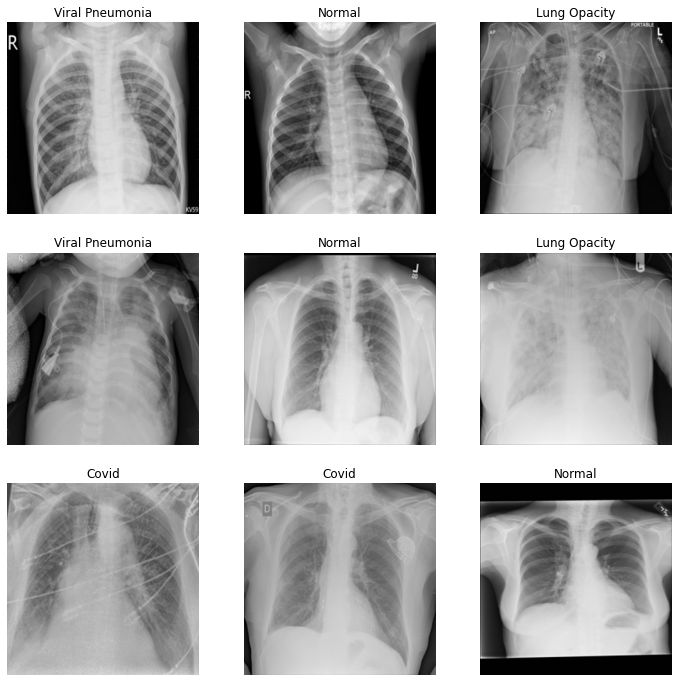

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3,3, i+1)
    img, label = training_data.next()
    plt.imshow(img[0], cmap='gray')
    dic = {0:'Covid', 1:'Lung Opacity', 2:'Normal', 3:'Viral Pneumonia'}
    plt.title(dic.get(np.where(label[0]==1)[0][0]))
    plt.axis('off')
plt.show()

**2.Model definitions**

**2a) VGG16 based model**

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16
vgg_features = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(299,299,3) )
vgg_features.trainable = False

# Use below code to determine which convolutional layers will be frozen and trainable during training
# Due to time and computational limitations we will not train a convolutional layer
#for layer in vgg_features.layers[:]:
#    layer.trainable = False

# vgg_features.summary()

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg_model = tf.keras.Sequential([
  vgg_features,
  tf.keras.layers.MaxPooling2D(pool_size=(4,4)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation = 'relu'),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(len(classes), activation = 'softmax')
]) 

In [ ]:
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 512)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 14,846,084
Trainable params: 131,396
Non-trainable params: 14,714,688
______________________________________

In [ ]:
vgg_model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics = [tf.keras.metrics.Recall(class_id=i) for i in range(4)])

In [ ]:
#@title code to plot model summary

#from tensorflow.keras.utils import plot_model
#from IPython.display import Image
#plot_model(model, to_file='conv_base.png', show_shapes=True)
#Image(filename='conv_base.png')

**2b) DenseNet201 based model**

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/densenet/DenseNet201
dnet_features = tf.keras.applications.densenet.DenseNet201(
    include_top=False,
    weights='imagenet',
    input_shape=(299,299,3) )
dnet_features.trainable = False

#resnet_features.summary()

74850304/74836368 [==============================] - 0s 0us/step


In [ ]:
dnet_model = tf.keras.Sequential([
  dnet_features,
  tf.keras.layers.MaxPooling2D(pool_size=(4,4)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation = 'relu'),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(len(classes), activation = 'softmax')
])

In [ ]:
dnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 9, 9, 1920)        18321984  
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 1920)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 7680)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                491584    
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 18,813,828
Trainable params: 491,844
Non-trainable params: 18,321,984
____________________________________

In [ ]:
dnet_model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics = [tf.keras.metrics.Recall(class_id=i) for i in range(4)])

**3.Training**

**3a) VGG16 based model**

In [ ]:
#@title Training

# Here there is a "problem". Ideally I would like to monitor the val_recalls but my code fails.
# Thus the approach is to the save all models and then keep the one that val_recalls are higher at least for the 3 disease classes.
# This is not optional but it is likely to give a model very close (if not the optional) to the one we would take if we monitored the val_recalls

# https://keras.io/api/callbacks/model_checkpoint/
filepath = 'vgg_model.epoch{epoch:02d}.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
																								verbose=0, 
																								save_best_only=False)

steps_per_epoch = np.ceil(training_data.samples/training_data.batch_size) # = 4304/32 = 134.5 (i.e. iterations)

vgg_history = vgg_model.fit(training_data, 
                epochs = 20,
                verbose = 1,
                callbacks = [checkpoint],
                steps_per_epoch = steps_per_epoch,
                validation_data = validation_data)

Epoch 1/20
135/135 [==============================] - 69s 390ms/step - loss: 0.8079 - recall: 0.3188 - recall_1: 0.4730 - recall_2: 0.5428 - recall_3: 0.7147 - val_loss: 0.6216 - val_recall: 0.5746 - val_recall_1: 0.6343 - val_recall_2: 0.6269 - val_recall_3: 0.9478
Epoch 2/20
135/135 [==============================] - 47s 345ms/step - loss: 0.5080 - recall: 0.6757 - recall_1: 0.7119 - recall_2: 0.7370 - recall_3: 0.9331 - val_loss: 0.5601 - val_recall: 0.8507 - val_recall_1: 0.6866 - val_recall_2: 0.5224 - val_recall_3: 0.8881
Epoch 3/20
135/135 [==============================] - 47s 348ms/step - loss: 0.4105 - recall: 0.7807 - recall_1: 0.7704 - recall_2: 0.7751 - recall_3: 0.9545 - val_loss: 0.4928 - val_recall: 0.6269 - val_recall_1: 0.6940 - val_recall_2: 0.8209 - val_recall_3: 0.9403
Epoch 4/20
135/135 [==============================] - 47s 347ms/step - loss: 0.3397 - recall: 0.8336 - recall_1: 0.8020 - recall_2: 0.8206 - recall_3: 0.9600 - val_loss: 0.4583 - val_recall: 0.7164 -

In [ ]:
#@title Save history metrics

# losses
loss = vgg_history.history['loss']
val_loss = vgg_history.history['val_loss']
with open('vgg_losses.pickle', 'wb') as f: 
  pickle.dump([loss, val_loss], f)

# recalls
recalls = [vgg_history.history['recall'], vgg_history.history['recall_1'],
           vgg_history.history['recall_2'], vgg_history.history['recall_3']]
val_recalls = [vgg_history.history['val_recall'], vgg_history.history['val_recall_1'],
           vgg_history.history['val_recall_2'], vgg_history.history['val_recall_3']]
with open('vgg_recalls.pickle', 'wb') as f: 
  pickle.dump([recalls, val_recalls], f)

**3b) DenseNet201 based model**

In [ ]:
#@title Training
filepath = 'dnet_model.epoch{epoch:02d}.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
																								verbose=0, 
																								save_best_only=False)

steps_per_epoch = np.ceil(training_data.samples/training_data.batch_size) # = 4304/32 = 134.5 (i.e. iterations)

dnet_history = dnet_model.fit(training_data, 
                epochs = 20,
                verbose = 1,
                callbacks = [checkpoint],
                steps_per_epoch=steps_per_epoch,
                validation_data = validation_data)

Epoch 1/20
135/135 [==============================] - 71s 410ms/step - loss: 0.7435 - recall_4: 0.5846 - recall_5: 0.6626 - recall_6: 0.6478 - recall_7: 0.8987 - val_loss: 0.5171 - val_recall_4: 0.7612 - val_recall_5: 0.8284 - val_recall_6: 0.5970 - val_recall_7: 0.9851
Epoch 2/20
135/135 [==============================] - 43s 320ms/step - loss: 0.2904 - recall_4: 0.8736 - recall_5: 0.8318 - recall_6: 0.8429 - recall_7: 0.9703 - val_loss: 0.4123 - val_recall_4: 0.9104 - val_recall_5: 0.7537 - val_recall_6: 0.6791 - val_recall_7: 0.9776
Epoch 3/20
135/135 [==============================] - 43s 316ms/step - loss: 0.2362 - recall_4: 0.8987 - recall_5: 0.8597 - recall_6: 0.8699 - recall_7: 0.9758 - val_loss: 0.4294 - val_recall_4: 0.9254 - val_recall_5: 0.7612 - val_recall_6: 0.6642 - val_recall_7: 0.9851
Epoch 4/20
135/135 [==============================] - 42s 308ms/step - loss: 0.1805 - recall_4: 0.9442 - recall_5: 0.8820 - recall_6: 0.8931 - recall_7: 0.9870 - val_loss: 0.4284 - val_re

In [ ]:
#@title Save history metrics

# losses
loss = dnet_history.history['loss']
val_loss = dnet_history.history['val_loss']
with open('dnet_losses.pickle', 'wb') as f: 
  pickle.dump([loss, val_loss], f)

# recalls
recalls = [dnet_history.history['recall_4'], dnet_history.history['recall_5'],
           dnet_history.history['recall_6'], dnet_history.history['recall_7']]
val_recalls = [dnet_history.history['val_recall_4'], dnet_history.history['val_recall_5'],
           dnet_history.history['val_recall_6'], dnet_history.history['val_recall_7']]
with open('dnet_recalls.pickle', 'wb') as f: 
  pickle.dump([recalls, val_recalls], f)

**4.Plots**

In this section we plot the following :


*   Loss history (train & validation)
*   Recall history per class (train & validation)
*   Validation recall history (in order to decide which model to keep)



**4a) VGG16 based model**

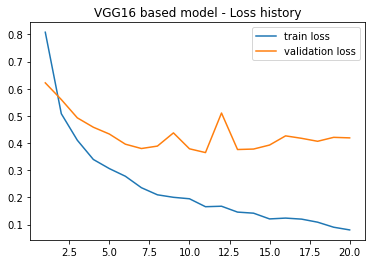

In [ ]:
#@title Loss history
plt.figure()
plt.title('VGG16 based model - Loss history')
x = range(1,21)
plt.plot(x, vgg_history.history['loss'])
plt.plot(x, vgg_history.history['val_loss'])
plt.legend(['train loss', 'validation loss'])

<Figure size 432x288 with 0 Axes>

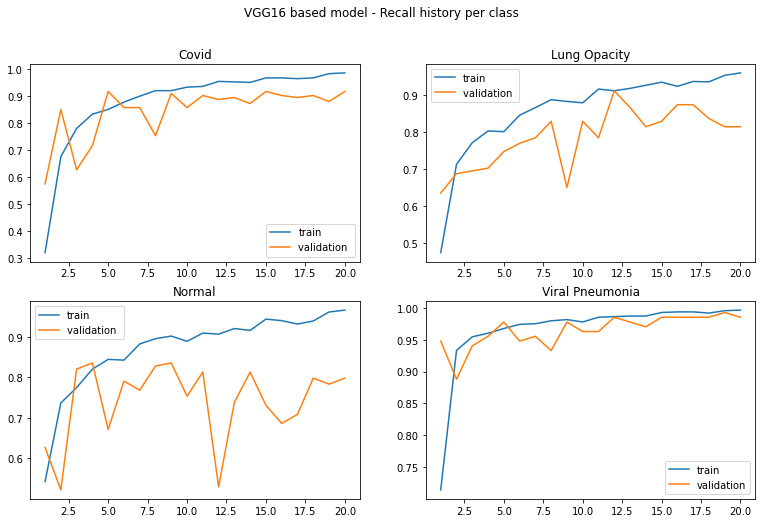

In [ ]:
#@title Recall history per class
plt.figure()

fig, ax = plt.subplots(2, 2, figsize=(13,8)) 
fig.suptitle("VGG16 based model - Recall history per class") 

x = range(1, 21)

ax[0, 0].plot(x, vgg_history.history['recall']); ax[0, 0].plot(x, vgg_history.history['val_recall'])
ax[0, 0].legend(['train', 'validation ']); ax[0, 0].set_title("Covid")

ax[0, 1].plot(x, vgg_history.history['recall_1']); ax[0, 1].plot(x, vgg_history.history['val_recall_1'])
ax[0, 1].legend(['train', 'validation ']); ax[0, 1].set_title("Lung Opacity")

ax[1, 0].plot(x, vgg_history.history['recall_2']); ax[1, 0].plot(x, vgg_history.history['val_recall_2'])
ax[1, 0].legend(['train', 'validation ']); ax[1, 0].set_title("Normal")

ax[1, 1].plot(x, vgg_history.history['recall_3']); ax[1, 1].plot(x, vgg_history.history['val_recall_3'])
ax[1, 1].legend(['train', 'validation']); ax[1, 1].set_title("Viral Pneumonia")

plt.show()

**Which model to pick ?**


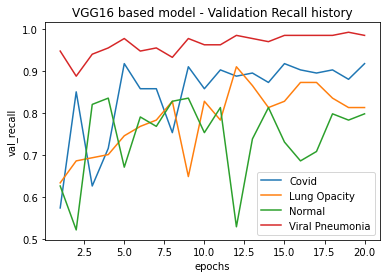

In [ ]:
#@title Validation Recall history
plt.figure()
plt.title('VGG16 based model - Validation Recall history')

x = range(1,21)

plt.plot(x, vgg_history.history['val_recall'])
plt.plot(x, vgg_history.history['val_recall_1'])
plt.plot(x, vgg_history.history['val_recall_2'])
plt.plot(x, vgg_history.history['val_recall_3'])

plt.xlabel('epochs')
plt.ylabel('val_recall')
plt.legend(['Covid', 'Lung Opacity', 'Normal', 'Viral Pneumonia'])

Based on the above graph, the training results of section 3a, and keeping in mind that we want to maximize validation recall scores of the three diseases, we keep the model of epoch 16.

In [ ]:
#@title Selected model validation recall report
lst = []
#print('\033[1m Selected model validation recall report \033[0m')
for cls, valrec in zip(classes, ['val_recall', 'val_recall_1', 'val_recall_2', 'val_recall_3']):
  x = round(vgg_history.history[valrec][15], 2)
  lst.append(x)
  print('{} class : {} '.format(cls, x))

print('Overall : {}'.format(round(sum(lst)/len(lst), 2)))

COVID class : 0.9 
Lung_Opacity class : 0.87 
Normal class : 0.69 
Viral Pneumonia class : 0.99 
Overall : 0.86


**4b) DenseNet201 based model**

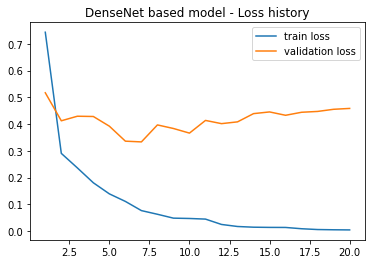

In [ ]:
#@title Loss history
plt.figure()
plt.title('DenseNet based model - Loss history')
x = range(1,21)
plt.plot(x, dnet_history.history['loss'])
plt.plot(x, dnet_history.history['val_loss'])
plt.legend(['train loss', 'validation loss'])

<Figure size 432x288 with 0 Axes>

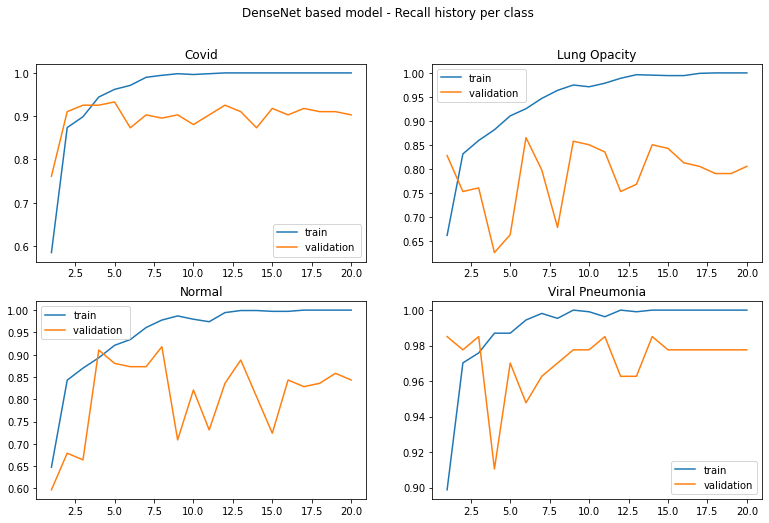

In [ ]:
#@title Recall history per class
plt.figure()

fig, ax = plt.subplots(2, 2, figsize=(13,8)) 
fig.suptitle("DenseNet based model - Recall history per class") 

x = range(1, 21)

ax[0, 0].plot(x, dnet_history.history['recall_4']); ax[0, 0].plot(x, dnet_history.history['val_recall_4'])
ax[0, 0].legend(['train', 'validation ']); ax[0, 0].set_title("Covid")

ax[0, 1].plot(x, dnet_history.history['recall_5']); ax[0, 1].plot(x, dnet_history.history['val_recall_5'])
ax[0, 1].legend(['train', 'validation ']); ax[0, 1].set_title("Lung Opacity")

ax[1, 0].plot(x, dnet_history.history['recall_6']); ax[1, 0].plot(x, dnet_history.history['val_recall_6'])
ax[1, 0].legend(['train', 'validation ']); ax[1, 0].set_title("Normal")

ax[1, 1].plot(x, dnet_history.history['recall_7']); ax[1, 1].plot(x, dnet_history.history['val_recall_7'])
ax[1, 1].legend(['train', 'validation']); ax[1, 1].set_title("Viral Pneumonia")

plt.show()

**Which model to pick ?**

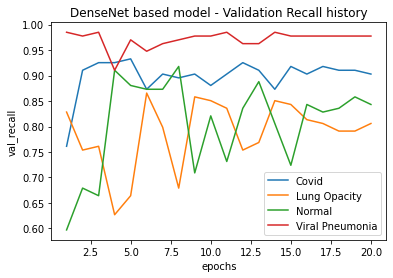

In [ ]:
#@title Validation Recall history
plt.figure()
plt.title('DenseNet based model - Validation Recall history')

x = range(1,21)

plt.plot(x, dnet_history.history['val_recall_4'])
plt.plot(x, dnet_history.history['val_recall_5'])
plt.plot(x, dnet_history.history['val_recall_6'])
plt.plot(x, dnet_history.history['val_recall_7'])

plt.xlabel('epochs')
plt.ylabel('val_recall')
plt.legend(['Covid', 'Lung Opacity', 'Normal', 'Viral Pneumonia'])

Based on the above graph, the training results of section 3b, and keeping in mind that we want to maximize validation recall scores of the three diseases, we keep the model of epoch 15.

In [ ]:
#@title Selected model validation recall report
lst = []
#print('\033[1m Selected model validation recall report \033[0m')
for cls, valrec in zip(classes, ['val_recall_4', 'val_recall_5', 'val_recall_6', 'val_recall_7']):
  x = round(dnet_history.history[valrec][14], 2)
  lst.append(x)
  print('{} class : {} '.format(cls, x))

print('Overall : {}'.format(round(sum(lst)/len(lst), 2)))

COVID class : 0.92 
Lung_Opacity class : 0.84 
Normal class : 0.72 
Viral Pneumonia class : 0.98 
Overall : 0.86


**5.Testing - Classification Reports**

**5a) VGG16 based model**

In [ ]:
#load the chosen vgg based model
import_path = 'vgg_model.epoch16.h5'
final_vgg_model = tf.keras.models.load_model(import_path)

In [ ]:
#we could train the selected model on validation data as well
final_vgg_model.fit(validation_data, epochs = 16, verbose=0)

In [ ]:
#@title Classification report
test_labels=test_data.classes 

predictions=final_vgg_model.predict(test_data, verbose=0)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       135
           1       0.82      0.82      0.82       135
           2       0.79      0.82      0.80       135
           3       0.96      0.96      0.96       135

    accuracy                           0.86       540
   macro avg       0.86      0.86      0.86       540
weighted avg       0.86      0.86      0.86       540



**5b) DenseNet201 based model**

In [ ]:
#load the chosen densenet based model
import_path = 'dnet_model.epoch15.h5'
final_dnet_model = tf.keras.models.load_model(import_path)

In [ ]:
#we could train the final chosen model to the validation data as well
final_dnet_model.fit(validation_data, epochs = 15, verbose = 0)

In [ ]:
#@title Classification report
test_labels=test_data.classes 

predictions=final_dnet_model.predict(test_data, verbose=0)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       135
           1       0.79      0.81      0.80       135
           2       0.83      0.86      0.85       135
           3       0.99      0.98      0.98       135

    accuracy                           0.88       540
   macro avg       0.88      0.88      0.88       540
weighted avg       0.88      0.88      0.88       540



**6.Explainability**

**6A) Grad Cam Heatmap**

source : https://arxiv.org/pdf/1610.02391.pdf

In [ ]:
#@title function: make_gradcam_heatmap(img_array, model, features, classifier_layer_names)

def make_gradcam_heatmap(
    img_array, model, features, classifier_layer_names):

    # We create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = tf.keras.Input(shape=features.output.shape[1:])  # features
    x = classifier_input
    for layer_name in classifier_layer_names:                           # classifier_layer_names
        x = model.get_layer(layer_name)(x)                              # model
    classifier_model = tf.keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        z = img_array.reshape(1, 299, 299, 3)                          # img_array
        last_conv_layer_output = features(z)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap,img_array

# example 
# make_gradcam_heatmap(test_data[0][0][0], final_model, features, classifier_layer_names)

In [ ]:
#@title function: display_gradcam(img_array, heatmap, alpha)

def display_gradcam(img_array, heatmap, alpha):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img_array
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    #superimposed_img.save(cam_path)

    # Display Grad CAM
    #plt.imshow(superimposed_img)
    #plt.show()
    return superimposed_img

An **example** describing the results of the make_gradcam_heatmap and display_gradcam functions. We use a test image classified correctly by both models.

In [ ]:
#@title load the final vgg based model along with its features

vgg_features = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(299,299,3) )
vgg_features.trainable = False

import_path = '/vgg_model.epoch16.h5'
final_vgg_model = tf.keras.models.load_model(import_path)

final_vgg_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 512)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 14,846,084
Trainable params: 131,396
Non-tr

In [ ]:
vgg_classifier_layer_names = ['max_pooling2d', 'flatten', 'dense', 'dense_1']

In [ ]:
#@title load the final dnet based model along with its features

dnet_features = tf.keras.applications.densenet.DenseNet201(
    include_top=False,
    weights='imagenet',
    input_shape=(299,299,3) )

import_path = '/dnet_model.epoch15.h5'
final_dnet_model = tf.keras.models.load_model(import_path)#, custom_objects={'KerasLayer':hub.KerasLayer})

final_dnet_model.summary()

74850304/74836368 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 9, 9, 1920)        18321984  
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 1920)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 7680)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                491584    
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 18,813,828
Trainable params: 491,844
Non-

In [ ]:
dnet_classifier_layer_names = ['max_pooling2d_1', 'flatten_1', 'dense_2', 'dense_3']

In [ ]:
# image correctly predicted by both models
test_batch, label_batch = test_data[0]

# try randomly first batch image
img = test_batch[0]
test_img = np.reshape(img, (1, img.shape[0], img.shape[1], img.shape[2]))
#print(img.shape)
img_label = label_batch[0]
print('The real label is {}'.format(classes[np.argmax(img_label)]))

print('The VGG16 based model predicts {}'.format(classes[np.argmax(final_vgg_model.predict(test_img))]))
print('The DenseNet201 based model predicts {}'.format(classes[np.argmax(final_dnet_model.predict(test_img))]))

The real label is COVID
The VGG16 based model predicts COVID
The DenseNet201 based model predicts COVID


In [ ]:
vgg_heatmap, vgg_img_array = make_gradcam_heatmap(test_img, final_vgg_model, vgg_features, vgg_classifier_layer_names)
dnet_heatmap, dnet_img_array = make_gradcam_heatmap(test_img, final_dnet_model, dnet_features, dnet_classifier_layer_names)

In [ ]:
vgg_heatmap.shape

(9, 9)

Text(0.5, 1.0, 'DenseNet201 model heatmap')

<Figure size 432x288 with 0 Axes>

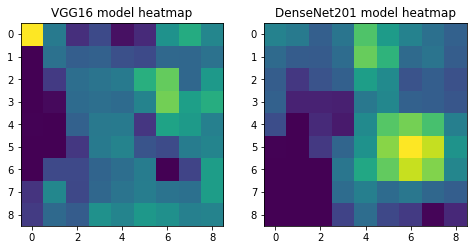

In [ ]:
#@title Grad Cam Heatmaps

plt.figure()
fig, ax = plt.subplots(1, 2, figsize=(8,4)) 
ax[0].imshow(vgg_heatmap); ax[0].set_title('VGG16 model heatmap')
ax[1].imshow(dnet_heatmap); ax[1].set_title('DenseNet201 model heatmap')

<Figure size 432x288 with 0 Axes>

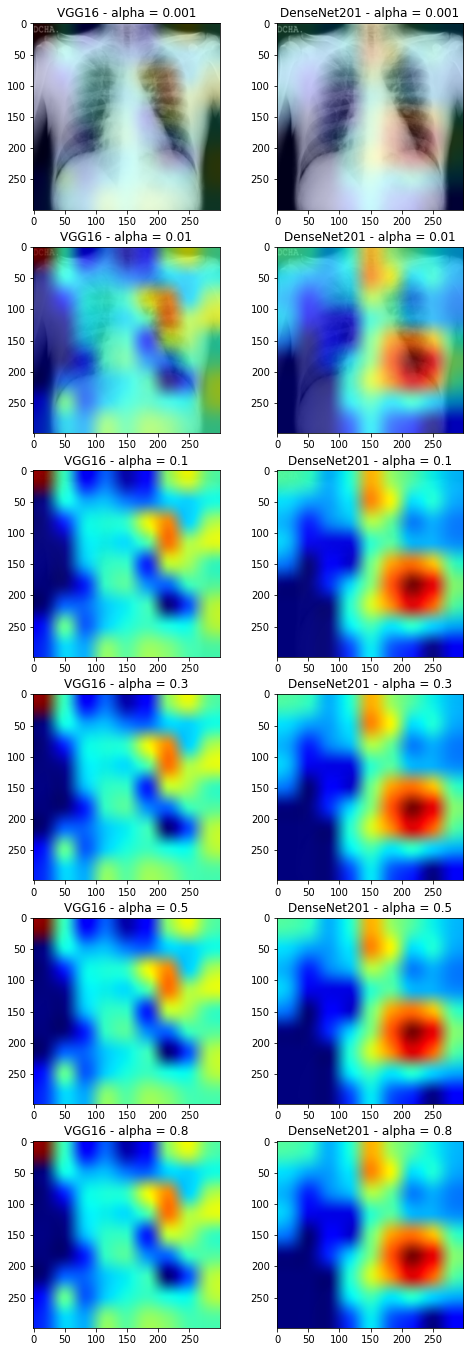

In [ ]:
#@title Plot superimposed images

plt.figure()

fig, ax = plt.subplots(6, 2, figsize=(8, 24))

j = 0
for a in [0.001, 0.01, 0.1, 0.3, 0.5, 0.8]:
  ax[j, 0].imshow(display_gradcam(img, vgg_heatmap, alpha=a))
  ax[j, 0].set_title("VGG16 - alpha = {}".format(a))
  ax[j, 1].imshow(display_gradcam(img, dnet_heatmap, alpha=a))
  ax[j, 1].set_title("DenseNet201 - alpha = {}".format(a))
  j += 1

**6B) MoRF - AOPC**

Below we compute the Area Over Perturbation Curves as defined in the following article https://arxiv.org/pdf/1509.06321.pdf

First we compute the perturbations per learned model and then print the curves

In [ ]:
#@title function: perturbations(model, features, classifier_layer_names)

def perturbations(model, features, classifier_layer_names):

  L = 81 # heatmap.shape[0]*heatmap.shape[0] = 9 * 9 = 81

  samples = 0

  images_tested = 0

  all_test_differences = []

  for image_batch, label_batch in test_data:
    
    if samples==540: # stop iterating when all test data are seen once
        break

    for i in range(image_batch.shape[0]): # gia ka8e eikona sto batch

      test_img_differences = []

      # initial image
      img = image_batch[i] # img.shape = (299, 299, 3)
      z = np.reshape(img, (1,299,299,3))
      y_pred = np.argmax(model.predict(z), axis = 1) # model.predict(z) is a prob distribution array of 4 elements
                                                     # y_pred returns the predicted label
      if y_pred==np.argmax(label_batch[i]): # if model correctly classifies the image, then compute perturbed images
                                            # note that label_batch[i] is an one-hot encoded 4 element vector, thus need argmax to compare to y_pred
        
        images_tested += 1
        
        # get class probability to get heatmap
        pred = np.max(model.predict(z), axis = 1)[0]

        # grad cam algorithm
        heatmap, img_array = make_gradcam_heatmap(img, model, features, classifier_layer_names)

        regions = {}
        for i in range(heatmap.shape[0]):
          for j in range(0, heatmap.shape[0]):
            #print('square-region ({},{}) has intensity {}'.format(i,j,heatmap[i,j]))
            #print(i,j)
            regions[i,j] = heatmap[i,j]
        
        sorted_regions = sorted(regions.items(), key=lambda x: x[1], reverse=True)

        # compute perturbations
        for step in range(1, L+1):

          # perturbed image at step "step"
          gaussian = np.random.normal(0, 0.1, (34, 34)) # each region has shape (34, 34)
          p_img = img
          region_row = sorted_regions[step-1][0][0]
          region_column = sorted_regions[step-1][0][1]
          if region_row != 8 and region_column != 8: 
            p_img[region_row*34:(region_row+1)*34, region_column*34:(region_column+1)*34, 0] = img[region_row*34:(region_row+1)*34, region_column*34:(region_column+1)*34, 0] + gaussian
            p_img[region_row*34:(region_row+1)*34, region_column*34:(region_column+1)*34, 1] = img[region_row*34:(region_row+1)*34, region_column*34:(region_column+1)*34, 1] + gaussian
            p_img[region_row*34:(region_row+1)*34, region_column*34:(region_column+1)*34, 2] = img[region_row*34:(region_row+1)*34, region_column*34:(region_column+1)*34, 2] + gaussian
          elif region_row == 8 and region_column != 8 :
            p_img[region_row*34:-1, region_column*34:(region_column+1)*34, 0] = img[region_row*34:-1, region_column*34:(region_column+1)*34, 0] + gaussian[:26,:]
            p_img[region_row*34:-1, region_column*34:(region_column+1)*34, 1] = img[region_row*34:-1, region_column*34:(region_column+1)*34, 1] + gaussian[:26,:]
            p_img[region_row*34:-1, region_column*34:(region_column+1)*34, 2] = img[region_row*34:-1, region_column*34:(region_column+1)*34, 2] + gaussian[:26,:]
          elif region_row != 8 and region_column == 8 :
            p_img[region_row*34:(region_row+1)*34, region_column*34:-1, 0] = img[region_row*34:(region_row+1)*34, region_column*34:-1, 0] + gaussian[:,:26]
            p_img[region_row*34:(region_row+1)*34, region_column*34:-1, 1] = img[region_row*34:(region_row+1)*34, region_column*34:-1, 1] + gaussian[:,:26]
            p_img[region_row*34:(region_row+1)*34, region_column*34:-1, 2] = img[region_row*34:(region_row+1)*34, region_column*34:-1, 2] + gaussian[:,:26]
          else :
            p_img[region_row*34:-1, region_column*34:-1, 0] = img[region_row*34:-1, region_column*34:-1, 0] + gaussian[:26, :26]
            p_img[region_row*34:-1, region_column*34:-1, 1] = img[region_row*34:-1, region_column*34:-1, 1] + gaussian[:26, :26]
            p_img[region_row*34:-1, region_column*34:-1, 2] = img[region_row*34:-1, region_column*34:-1, 2] + gaussian[:26, :26]
          
          p_z = np.reshape(p_img, (1,299,299,3))
          p = model.predict(p_z)
          perturbed_pred = p[0][y_pred[0]] # probablity of class for the perturbed image

          test_img_differences.append(pred-perturbed_pred) # probability - probability
          
          img = p_img
        
        all_test_differences.append(test_img_differences)

    samples += label_batch.shape[0]

  print('The perturbations are computed only for images that are correctly predicted by the model. Out of the initial 540, eventually {} test images were used'.format(images_tested))

  return all_test_differences 

In [ ]:
dnet_perturbations = perturbations(final_dnet_model, dnet_features, dnet_classifier_layer_names)
with open('dnet_perturbations.pickle', 'wb') as f: 
  pickle.dump(dnet_perturbations, f)

The perturbations are computed only for images that are correctly predicted by the model. Out of the initial 540, eventually 483 test images were used


In [ ]:
vgg_perturbations = perturbations(final_vgg_model, vgg_features, vgg_classifier_layer_names)
with open('vgg_perturbations.pickle', 'wb') as f: 
  pickle.dump(vgg_perturbations, f)

The perturbations are computed only for images that are correctly predicted by the model. Out of the initial 540, eventually 481 test images were used


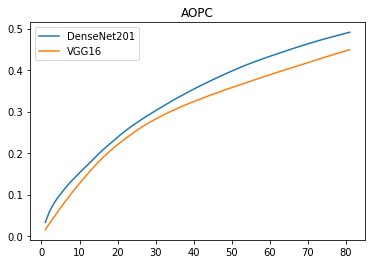

In [ ]:
# below graph displays the AOPC values as function of the perturbation steps

dnet_lst = []
for j in range(81):
  r = 0
  for i in range(len(dnet_perturbations)):
    for k in range(j+1):
      r = r + dnet_perturbations[i][k]
  res = (1/(2+j)) * (1/len(dnet_perturbations)) * r
  dnet_lst.append(res)

vgg_lst = []
for j in range(81):
  r = 0
  for i in range(len(vgg_perturbations)):
    for k in range(j+1):
      r = r + vgg_perturbations[i][k]
  res = (1/(2+j)) * (1/len(vgg_perturbations)) * r
  vgg_lst.append(res)

x = range(1, 82)

plt.plot(x, dnet_lst)
plt.plot(x, vgg_lst)
plt.legend(['DenseNet201', 'VGG16'])
plt.title('AOPC')
plt.show()